In [203]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
from tblib import lattice
from tblib import hamiltonian

reload(lattice)
reload(hamiltonian)

<module 'tblib.hamiltonian' from 'c:\\Users\\atsch\\Desktop\\MasterVorlesungen\\Masterthesis\\Code\\tblib\\hamiltonian.py'>

In [204]:
k=np.linspace(0,np.pi, 100)

In [205]:
N=2

lat = lattice.dDiagonallyStripedLattice(N=N)
ham = hamiltonian.Model(N=N, kind='dDSL', delta=[0.01,0.01], U=[0,5])
 

#lat.plot_lattice();

In [206]:
ham.delta

[0.01, 0.01]

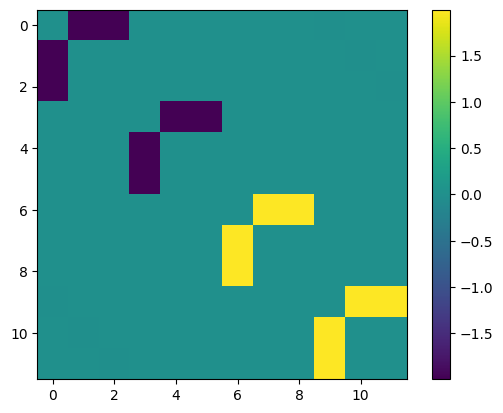

In [207]:
plt.imshow(np.real(ham.Hk(k[2], k[2])[0]))
plt.colorbar()

In [208]:
#ham.SFW(1,0)

In [209]:
ham.DeltaN(3,0,True)

([0j, (-1.8088243419185752+0j)],
 [(1.0000000000000004+0j), (1.0000000000000062+0j)])

In [210]:
ham.Deltra(10,T=0,HF=True)

(array([[ 1.00000000e-02+0.00000000e+00j,  5.00000000e-03+0.00000000e+00j,
          2.50000000e-03+0.00000000e+00j,  1.25000000e-03+0.00000000e+00j,
          6.25000000e-04+0.00000000e+00j,  3.12500000e-04+0.00000000e+00j,
          1.56250000e-04+0.00000000e+00j,  7.81250000e-05+0.00000000e+00j,
          3.90625000e-05+0.00000000e+00j,  1.95312500e-05+0.00000000e+00j,
          9.76562500e-06+0.00000000e+00j,  4.88281250e-06+0.00000000e+00j,
          2.44140625e-06+0.00000000e+00j,  1.22070313e-06+0.00000000e+00j,
          6.10351563e-07+0.00000000e+00j,  3.05175781e-07+0.00000000e+00j,
          1.52587891e-07+0.00000000e+00j,  7.62939453e-08+0.00000000e+00j,
          3.81469727e-08+0.00000000e+00j,  1.90734863e-08+0.00000000e+00j,
          9.53674316e-09+0.00000000e+00j,  9.75608826e-07+0.00000000e+00j],
        [ 1.00000000e-02+0.00000000e+00j, -6.48736698e-01-6.00311901e-16j,
         -9.78105047e-01-9.00467851e-16j, -1.14278922e+00-1.05054583e-15j,
         -1.22513131e+00

In [211]:
ham.as_d

{0: [(0, 0)], 1: [(0, 1), (1, 0)]}

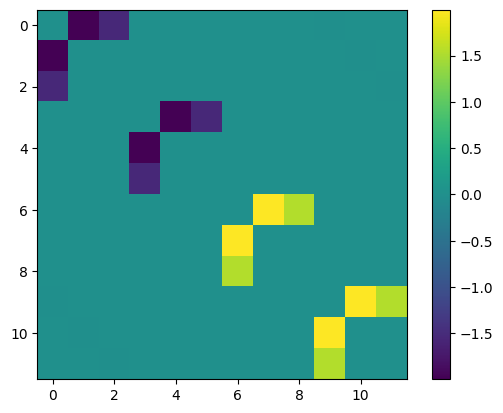

In [212]:
plt.imshow(np.real(ham.Hk(k[20], k[2])[0]))
plt.colorbar()

In [213]:
ham.delta

array([ 9.75608826e-07+0.00000000e+00j, -1.30734486e+00-1.20050667e-15j])

In [214]:
ham.Hk(k[20], k[2])[0]

array([[-0.        +0.j        , -1.99496846-0.12678398j,
        -1.53012803-1.1266094j ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , -0.01      +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [-1.99496846+0.12678398j, -0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
        -0.01      +0.j        ,  0.        +0.j        ],
       [-1.53012803+1.1266094j ,  0.        +0.j        ,
        -0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0. 